<a href="https://colab.research.google.com/github/albertocj1/Taxi-v3-Reinforcement-Learning/blob/main/Copy_of_Final_Taxi_v3_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium torch numpy matplotlib imageio[ffmpeg] --quiet

In [2]:
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video


# Select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


In [3]:
import gymnasium as gym

# Create the Taxi-v3 environment
env = gym.make("Taxi-v3")

# Print the observation space
print("Observation Space:", env.observation_space)

# Print the action space
print("Action Space:", env.action_space)

# Close the environment
env.close()

Observation Space: Discrete(500)
Action Space: Discrete(6)


In [4]:
#
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 80) #Linear
        self.relu = nn.ReLU() # non linear rectified linear activation unit
        self.layer2 = nn.Linear(80, 80)
        self.output_layer = nn.Linear(80, n_actions)
# defines the forward pass of the neural network. It specifies how the input data (x) flows through the layers to produce the output.
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.output_layer(x)
# Q-value predictions (output)
# Get the number of observations and actions from the environment (500, 6)
n_observations = env.observation_space.n
n_actions = env.action_space.n

# Instantiate the DQN model to learn optimal polivy
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [5]:
from collections import deque
import random
import torch
import numpy as np


class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones),
        )

    def __len__(self):
        return len(self.buffer)

In [6]:
def train_dqn(episodes,
              gamma,
              lr,
              batch_size,
              epsilon_decay,
              min_epsilon):

    env = gym.make("Taxi-v3")
    n_observations = env.observation_space.n
    n_actions = env.action_space.n

    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    memory = ReplayBuffer(5000)
    epsilon = 1.0
    rewards_history = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            # ε-greedy policy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                # Convert state to one-hot encoding for network input
                state_one_hot = torch.zeros(n_observations, dtype=torch.float32).to(device)
                state_one_hot[state] = 1.0
                state_tensor = state_one_hot.unsqueeze(0)

                with torch.no_grad():
                    action = torch.argmax(policy_net(state_tensor)).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Train network
            if len(memory) >= batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)

                # 🔹 Move tensors to GPU/CPU device and ensure correct shape
                # Convert states and next_states to one-hot encoding for batch processing
                states_one_hot = torch.zeros(batch_size, n_observations, dtype=torch.float32).to(device)
                states_one_hot[torch.arange(batch_size), states.long()] = 1.0

                next_states_one_hot = torch.zeros(batch_size, n_observations, dtype=torch.float32).to(device)
                next_states_one_hot[torch.arange(batch_size), next_states.long()] = 1.0

                actions = actions.to(device)
                rewards = rewards.to(device)
                dones = dones.to(device)


                q_values = policy_net(states_one_hot).gather(1, actions.unsqueeze(1)).squeeze()
                next_q_values = target_net(next_states_one_hot).max(1)[0]
                expected_q_values = rewards + gamma * next_q_values * (1 - dones)

                loss = criterion(q_values, expected_q_values.detach())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_history.append(total_reward)

        # Update target network
        if ep % 10 == 0: # Update target network every 10 episodes
             target_net.load_state_dict(policy_net.state_dict())


        print(f"Episode {ep+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    env.close()
    return rewards_history, policy_net

In [7]:
# Example hyperparameters
episodes = 10000
gamma = 0.99
lr = 0.001
batch_size = 64
epsilon_decay = 0.995
min_epsilon = 0.01

# Train the DQN agent
rewards, trained_policy_net = train_dqn(episodes, gamma, lr, batch_size, epsilon_decay, min_epsilon)

Streaming output truncated to the last 5000 lines.
Episode 5001/10000, Total Reward: 7, Epsilon: 0.01
Episode 5002/10000, Total Reward: 9, Epsilon: 0.01
Episode 5003/10000, Total Reward: 8, Epsilon: 0.01
Episode 5004/10000, Total Reward: 8, Epsilon: 0.01
Episode 5005/10000, Total Reward: 8, Epsilon: 0.01
Episode 5006/10000, Total Reward: 9, Epsilon: 0.01
Episode 5007/10000, Total Reward: 12, Epsilon: 0.01
Episode 5008/10000, Total Reward: -1, Epsilon: 0.01
Episode 5009/10000, Total Reward: 8, Epsilon: 0.01
Episode 5010/10000, Total Reward: 11, Epsilon: 0.01
Episode 5011/10000, Total Reward: 8, Epsilon: 0.01
Episode 5012/10000, Total Reward: 6, Epsilon: 0.01
Episode 5013/10000, Total Reward: 6, Epsilon: 0.01
Episode 5014/10000, Total Reward: 9, Epsilon: 0.01
Episode 5015/10000, Total Reward: 10, Epsilon: 0.01
Episode 5016/10000, Total Reward: 8, Epsilon: 0.01
Episode 5017/10000, Total Reward: 4, Epsilon: 0.01
Episode 5018/10000, Total Reward: -6, Epsilon: 0.01
Episode 5019/10000, Total 

In [8]:
# Create the Taxi-v3 environment with render_mode="rgb_array"
env = gym.make("Taxi-v3", render_mode="rgb_array")

# Define the video path and create an imageio writer
video_path = "taxi_dqn.mp4"
writer = imageio.get_writer(video_path, fps=15)

# Run multiple episodes and record the video
episodes_to_record = 20  # Record 10 episodes

for ep in range(episodes_to_record):
    state, _ = env.reset()
    done = False
    while not done:
        # Convert state to one-hot encoding for network input
        state_one_hot = torch.zeros(env.observation_space.n, dtype=torch.float32).to(device)
        state_one_hot[state] = 1.0
        state_tensor = state_one_hot.unsqueeze(0)

        with torch.no_grad():
            action = torch.argmax(trained_policy_net(state_tensor)).item()

        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state

        # Render the environment and append the frame to the video writer
        frame = env.render()
        writer.append_data(frame)

# Close the video writer and the environment
writer.close()
env.close()

print(f"Video saved to {video_path}")

# Display the video
Video(video_path)

Video saved to taxi_dqn.mp4


In [9]:
Video("taxi_dqn.mp4", embed=True)

In [10]:
def evaluate_agent(env, policy_net, episodes=20):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            # Convert state to one-hot encoding for network input
            state_one_hot = torch.zeros(env.observation_space.n, dtype=torch.float32).to(device)
            state_one_hot[state] = 1.0
            state_tensor = state_one_hot.unsqueeze(0)

            with torch.no_grad():
                action = torch.argmax(policy_net(state_tensor)).item()

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
        total_rewards.append(ep_reward)
    return np.mean(total_rewards), np.min(total_rewards), np.max(total_rewards)

# Create the Taxi-v3 environment for evaluation
eval_env = gym.make("Taxi-v3")

# Evaluate the trained agent
avg_reward, min_reward, max_reward = evaluate_agent(eval_env, trained_policy_net, episodes=20)
print(f"Average reward over {episodes} evaluation episodes: {avg_reward:.2f}")
print(f"Minimum reward over {episodes} evaluation episodes: {min_reward:.2f}")
print(f"Maximum reward over {episodes} evaluation episodes: {max_reward:.2f}")

# Close the environment
eval_env.close()

Average reward over 10000 evaluation episodes: 8.35
Minimum reward over 10000 evaluation episodes: 2.00
Maximum reward over 10000 evaluation episodes: 14.00


In [11]:
import gymnasium as gym
import numpy as np
import random

# Create the Taxi-v3 environment
env = gym.make("Taxi-v3")

# Initialize the Q-table
# The Q-table will have dimensions (number of states, number of actions)
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Define training parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay_rate = 0.999  # Epsilon decay rate
min_epsilon = 0.01  # Minimum epsilon
episodes = 10000  # Number of training episodes
max_steps_per_episode = 100  # Maximum steps per episode

# Training loop
rewards_history_qlearning = []

for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps_per_episode):
        # ε-greedy policy
        if random.random() < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state, :])  # Exploit learned values

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Update Q-table using the Q-learning formula
        q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action])

        state = next_state
        total_reward += reward

        if done:
            break

    # Epsilon decay
    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
    rewards_history_qlearning.append(total_reward)

    if (ep + 1) % 100 == 0:
        print(f"Episode {ep+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

env.close()

print("\nTraining finished.")

Episode 100/10000, Total Reward: -307, Epsilon: 0.90
Episode 200/10000, Total Reward: -316, Epsilon: 0.82
Episode 300/10000, Total Reward: -271, Epsilon: 0.74
Episode 400/10000, Total Reward: -343, Epsilon: 0.67
Episode 500/10000, Total Reward: -244, Epsilon: 0.61
Episode 600/10000, Total Reward: -253, Epsilon: 0.55
Episode 700/10000, Total Reward: -145, Epsilon: 0.50
Episode 800/10000, Total Reward: 9, Epsilon: 0.45
Episode 900/10000, Total Reward: -160, Epsilon: 0.41
Episode 1000/10000, Total Reward: -18, Epsilon: 0.37
Episode 1100/10000, Total Reward: -55, Epsilon: 0.33
Episode 1200/10000, Total Reward: -4, Epsilon: 0.30
Episode 1300/10000, Total Reward: -15, Epsilon: 0.27
Episode 1400/10000, Total Reward: 6, Epsilon: 0.25
Episode 1500/10000, Total Reward: -190, Epsilon: 0.22
Episode 1600/10000, Total Reward: -5, Epsilon: 0.20
Episode 1700/10000, Total Reward: -8, Epsilon: 0.18
Episode 1800/10000, Total Reward: -34, Epsilon: 0.17
Episode 1900/10000, Total Reward: -2, Epsilon: 0.15
E

In [12]:
# Evaluate the Q-learning agent
def evaluate_qlearning_agent(env, q_table, episodes=20):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            # Choose action based on the learned Q-table (greedy policy)
            action = np.argmax(q_table[state, :])

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
        total_rewards.append(ep_reward)
    return np.mean(total_rewards), np.min(total_rewards), np.max(total_rewards)

# Create the Taxi-v3 environment for evaluation
eval_env_qlearning = gym.make("Taxi-v3")

# Evaluate the trained Q-learning agent
avg_reward_qlearning, min_reward_qlearning, max_reward_qlearning = evaluate_qlearning_agent(eval_env_qlearning, q_table, episodes=20)
print(f"Average reward over {episodes} evaluation episodes (Q-learning): {avg_reward_qlearning:.2f}")
print(f"Minimum reward over {episodes} evaluation episodes (Q-learning): {min_reward_qlearning:.2f}")
print(f"Maximum reward over {episodes} evaluation episodes (Q-learning): {max_reward_qlearning:.2f}")

# Close the environment
eval_env_qlearning.close()

Average reward over 10000 evaluation episodes (Q-learning): 7.35
Minimum reward over 10000 evaluation episodes (Q-learning): 3.00
Maximum reward over 10000 evaluation episodes (Q-learning): 13.00


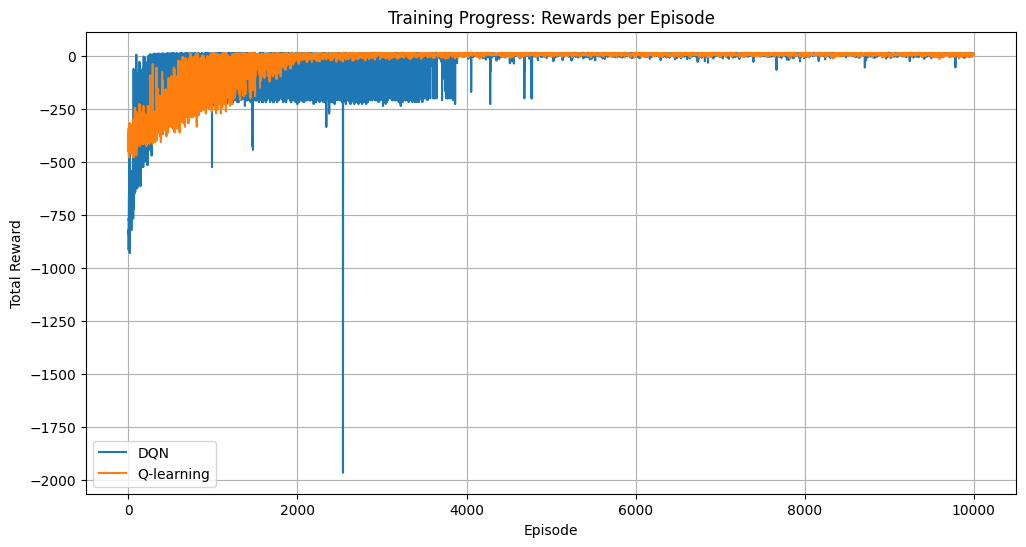

In [13]:
# Plot the rewards history for both DQN and Q-learning (if available)
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='DQN')
plt.plot(rewards_history_qlearning, label='Q-learning')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress: Rewards per Episode')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Create the Taxi-v3 environment with render_mode="rgb_array" for Q-learning
env_qlearning_video = gym.make("Taxi-v3", render_mode="rgb_array")

# Define the video path and create an imageio writer
video_path_qlearning = "taxi_qlearning.mp4"
writer_qlearning = imageio.get_writer(video_path_qlearning, fps=15)

# Run multiple episodes and record the video for Q-learning
episodes_to_record_qlearning = 20  # Record 20 episodes

for ep in range(episodes_to_record_qlearning):
    state, _ = env_qlearning_video.reset()
    done = False
    while not done:
        # Choose action based on the learned Q-table (greedy policy)
        action = np.argmax(q_table[state, :])

        next_state, _, terminated, truncated, _ = env_qlearning_video.step(action)
        done = terminated or truncated
        state = next_state

        # Render the environment and append the frame to the video writer
        frame = env_qlearning_video.render()
        writer_qlearning.append_data(frame)

# Close the video writer and the environment
writer_qlearning.close()
env_qlearning_video.close()

print(f"Video saved to {video_path_qlearning}")

# Display the video
Video(video_path_qlearning)

Video saved to taxi_qlearning.mp4


In [15]:
Video("taxi_qlearning.mp4", embed=True)

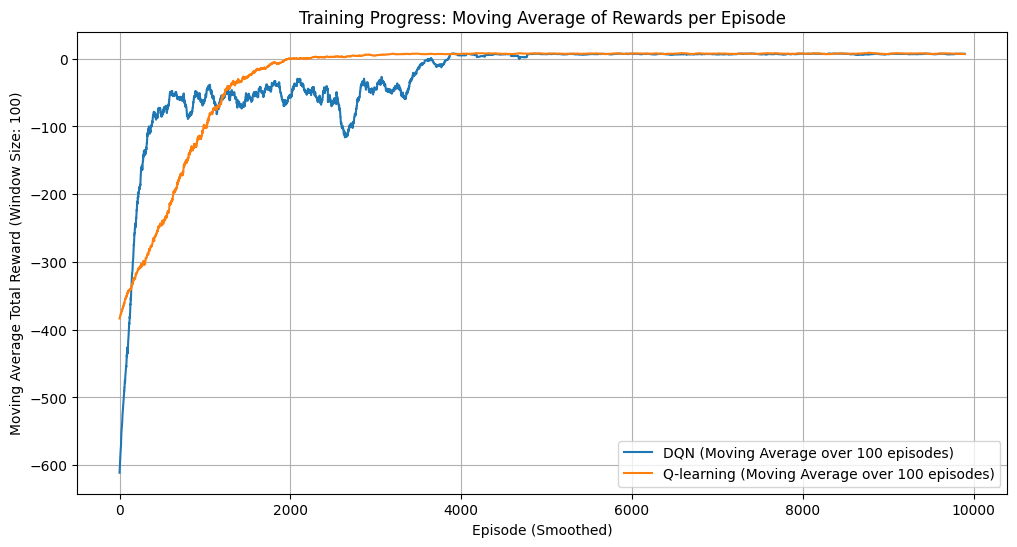